

**Objetivo:** resolver a EDO $$\dfrac{du}{dt}=\cos \pi t$$
com condição inicial $u(0)=1.$

Para esse problema a solução exata é conhecida, basta integrar, e é dada por $$u(t)=\frac{1}{2\pi} \sin 2\pi t +1.$$



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from scipy.optimize import minimize

In [2]:
import tensorflow as tf

# Verifica se há GPUs disponíveis
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs disponíveis: {len(gpus)}")
    for gpu in gpus:
        print(f"Nome da GPU: {gpu}")
else:
    print("Nenhuma GPU foi detectada. TensorFlow está rodando na CPU.")


Nenhuma GPU foi detectada. TensorFlow está rodando na CPU.


In [3]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [18]:
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(units = 60, activation='tanh'),
    tf.keras.layers.Dense(units = 60, activation='tanh'),
    tf.keras.layers.Dense(units = 1)
])

NN.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 60)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,841 (15.00 KB)

 Trainable params: 3,841 (15.00 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
optm = tf.keras.optimizers.Adam(learning_rate=1e-3)


---
Construindo a função de perda particular para o nosso problema.

Função de perda da EDO: $$L_{\text{ode}}=\frac{1}{n}\sum_{i=1}^{n}\left(\frac{dNN(t_{i})}{dt}-\cos2\pi t_{i}\right)^{2}$$
Função de perda da condição inicial: $$L_{\text{ic}}=\left(NN(0)-1\right)^{2}$$
Função de perda total: $$L_{\text{Total}}=L_{\text{ode}}+L_{\text{ic}}$$

In [6]:
def ode_system(t,net):
    t = t.reshape(-1,1) #transforma o vetor ([x,y,z,....]) em uma coluna :([x],[y],[z]...) pq é assim que o tensorflow vai ler
    t = tf.constant(t,dtype = tf.float32) #tranforma o nosso vetor de colunas em um tensor do tensorflow.
    t_0 = tf.zeros((1,1)) # tensor 1x1 2d que contem um 0 (REPRESENTA A CONDIÇÃO INICIAL - t = 0)
    one  = tf.ones((1,1)) # mesma coisa só que com 1 (REPRESENTA O VALOR DE U NA CONDIÇÃO INICIAL  --- U(0) = 1)
    
    with tf.GradientTape() as tape:
        tape.watch(t) # pega um tensor contante, no qual criamos, e observa ele. No caso estamos dizendo pro tensorflow que iremos fazer opetações de gradientes com essa variavel mais tarde.
        
        u = net(t) # calcula a saída da rede neural, que é a solução u(t)
        u_t = tape.gradient(u, t) # calcula a derivada da saída u em relação a t.
        
    ode_loss = u_t - tf.math.cos(2*np.pi*t) # função perda da EDO.
    IC_loss = net(t_0) - one # função perda da condição inicial.
    
    square_loss = tf.square(ode_loss) + tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss) # calcula a perda total
    
    return total_loss



**Treinamento da rede**

Epoch 0, Perda: 1.5367120504379272
Epoch 100, Perda: 0.48003649711608887
Epoch 200, Perda: 0.47419434785842896
Epoch 300, Perda: 0.3770250082015991
Epoch 400, Perda: 0.23417174816131592
Epoch 500, Perda: 0.1863938570022583
Epoch 600, Perda: 0.10381273925304413
Epoch 700, Perda: 0.029522038996219635
Epoch 800, Perda: 0.005237462464720011
Epoch 900, Perda: 0.0014014370972290635
Epoch 1000, Perda: 0.000942180457059294
Epoch 1100, Perda: 0.0007673937361687422
Epoch 1200, Perda: 0.000689694716129452
Epoch 1300, Perda: 0.0006454860558733344
Epoch 1400, Perda: 0.000642733066342771
Epoch 1500, Perda: 0.0005970413330942392
Epoch 1600, Perda: 0.0005786638939753175
Epoch 1700, Perda: 0.0005640126182697713
Epoch 1800, Perda: 0.0005490070325322449
Epoch 1900, Perda: 0.0011084283469244838
Epoch 2000, Perda: 0.0005246116197668016
Epoch 2100, Perda: 0.0005134590319357812
Epoch 2200, Perda: 0.0005028462619520724
Epoch 2300, Perda: 0.0004927063710056245
Epoch 2400, Perda: 0.00048640117165632546
Epoch 25

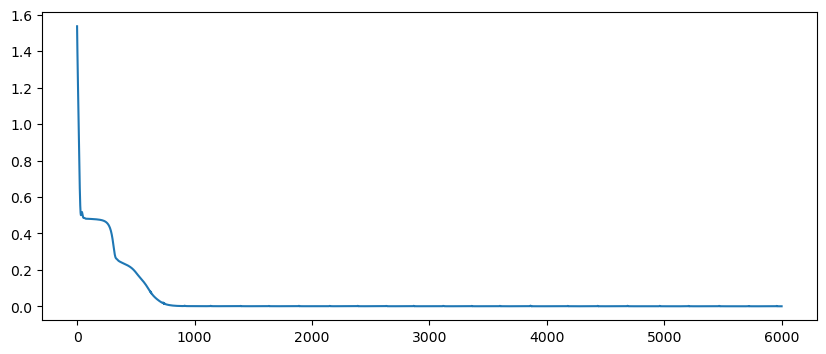

In [7]:
epochs = 6000

train_t = (np.random.rand(50)*2).reshape(-1,1) #pegando os dados para treinamento. Dados do domínio

train_loss_record = [] # lista para gravar o progresso do treinamento

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        train_loss = ode_system(train_t, NN)
        train_loss_record.append(train_loss)
        
        grad_w = tape.gradient(train_loss, NN.trainable_variables) # calcula os gradientes da função de perda (train_loss) em relação aos pesos da rede neural (NN.trainable_variables).
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Perda: {train_loss.numpy()}')
        
plt.figure(figsize = (10,4))
plt.plot(train_loss_record)
plt.show()



[0.5193254351615906, 0.5181365013122559, 0.5179411768913269, 0.5172615647315979, 0.5159568786621094, 0.5140199065208435, 0.5121709704399109, 0.5112077593803406, 0.5111784934997559, 0.5110375881195068, 0.5106260180473328, 0.5098150968551636, 0.5083703994750977, 0.5054206252098083, 0.4997352361679077, 0.4925171136856079, 0.4871774911880493, 0.46663638949394226, 0.45343875885009766, 0.44353359937667847, 0.43758490681648254, 0.4331592619419098, 0.42720404267311096, 0.41741907596588135, 0.40947994589805603, 0.40237441658973694, 0.39108046889305115, 0.3858923017978668, 0.3825957477092743, 0.3724548816680908, 0.36396244168281555, 0.3318136930465698, 0.2900225520133972, 0.28166836500167847, 0.2796444594860077, 0.2767468988895416, 0.2753067910671234, 0.27279871702194214, 0.2698075473308563, 0.2580753266811371, 0.24234451353549957, 0.22230373322963715, 0.1993643045425415, 0.18888521194458008, 0.17431104183197021, 0.15698003768920898, 0.15317721664905548, 0.1500900685787201, 0.14889173209667206, 

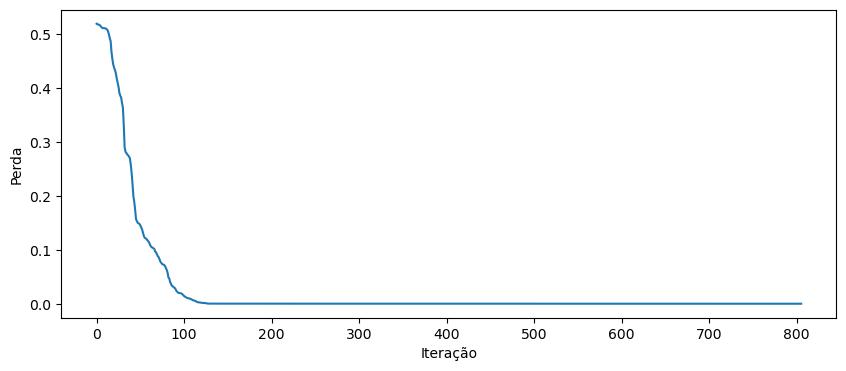

In [19]:
from scipy.optimize import minimize
def get_weights(model):
    weights = model.trainable_variables
    weights = [w.numpy().flatten() for w in weights]
    weights = np.concatenate(weights)
    return weights

def set_weights(model, flat_weights):
    weights = model.trainable_variables
    shapes = [w.shape.as_list() for w in weights]
    sizes = [np.prod(s) for s in shapes]
    new_weights = []
    pos = 0
    for s, shape in zip(sizes, shapes):
        new_weights.append(np.reshape(flat_weights[pos:pos+s], shape))
        pos += s
    for i, w in enumerate(weights):
        w.assign(new_weights[i])
        
def func_to_minimize(flat_weights):
    
    # Atualiza os pesos na rede neural
    set_weights(NN, flat_weights)

    # Calcula a perda e os gradientes
    with tf.GradientTape() as tape:
        train_loss = ode_system(train_t, NN)
    grad_w = tape.gradient(train_loss, NN.trainable_variables)
    # Achata os gradientes
    grad_flat = []
    for g in grad_w:
        grad_flat.append(tf.reshape(g, [-1]))
    grad_flat = tf.concat(grad_flat, axis=0)
    # Retorna a perda e o gradiente como arrays numpy
    return train_loss.numpy().astype(np.float64), grad_flat.numpy().astype(np.float64)

class LossHistory:
    def __init__(self):
        self.losses = []

    def __call__(self, xk):
        loss_value, _ = func_to_minimize(xk)
        self.losses.append(loss_value)

train_t = (np.random.rand(50)*2).reshape(-1,1) #pegando os dados para treinamento. Dados do domínio

initial_weights = get_weights(NN)

loss_history = LossHistory()

result = minimize(func_to_minimize, initial_weights, method='L-BFGS-B', jac=True, callback=loss_history, options={'maxiter': 5000})

set_weights(NN, result.x)
print(loss_history.losses)
plt.figure(figsize=(10,4))
plt.plot(loss_history.losses)
plt.xlabel('Iteração')
plt.ylabel('Perda')
plt.show()

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002AD08536480> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  


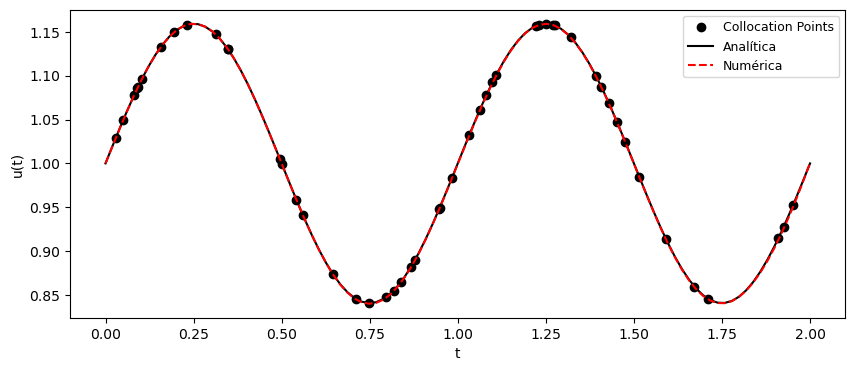

In [20]:
test_t = np.linspace(0,2,100)

train_u = np.sin(2*np.pi*train_t)/(2*np.pi) + 1
true_u = np.sin(2*np.pi*test_t)/(2*np.pi) + 1

pred_u = NN.predict(test_t).ravel()

plt.figure(figsize = (10,4))
plt.plot(train_t,train_u,'ok', label = 'Collocation Points')
plt.plot(test_t, true_u, '-k', label = 'Analítica')
plt.plot(test_t, pred_u, '--r', label ='Numérica')
plt.legend(fontsize = 9)
plt.xlabel('t', fontsize = 10)
plt.ylabel('u(t)', fontsize = 10)
plt.show()

In [21]:
x_min, x_max = -2, 2
t_min, t_max = 0, 1

def initial_condition(x):
    return np.where(np.abs(x) <= 1, 1-x**2, 0)

def analytical_solution(t,x):
    return np.where(np.abs(x+t) <= 1, 1-(x+t)**2, 0)

In [22]:
def create_model():
    initializer = tf.keras.initializers.GlorotNormal()
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(2,)), #entrada
        tf.keras.layers.Dense(80, activation='tanh'),
        tf.keras.layers.Dense(80, activation='tanh'),
        tf.keras.layers.Dense(80, activation='tanh'),
        tf.keras.layers.Dense(80, activation='tanh'),
        tf.keras.layers.Dense(1, activation=None) # saída
    ])
    return model

In [24]:
# parte da função de perda que corresponde a edp
def loss_function(model, x, t):
    with tf.GradientTape(persistent = True) as tape:
        tape.watch([x,t])
        u = model(tf.concat([t, x], axis =1))
        u_t = tape.gradient(u, t)
        u_x = tape.gradient(u, x)
    residual  = u_t - u_x
    return tf.reduce_mean(tf.square(residual))

 # função perda total
def total_loss(model, x, t, x_ic, u_ic):
    loss_phys = loss_function(model, x, t)
    u_pred = model(tf.concat([tf.zeros_like(x_ic), x_ic], axis=1))
    loss_ic = tf.reduce_mean(tf.square(u_ic - u_pred))
    return loss_phys + loss_ic

     
        

In [20]:
def train_model(model, epochs, x, t, x_ic, u_ic):
    optimizer = tf.keras.optimizers.Adam(learning_rate =1e-3)
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = total_loss(model, x, t, x_ic, u_ic)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        if epoch %100 == 0:
            print(f'epoch: {epoch}, Perda: {loss.numpy()}')

In [29]:
x_train = (np.random.rand(1000)*2*x_max+x_min).reshape(-1, 1) # amostra os pontos no intervalo [-2,2]
t_train = (np.random.rand(1000)*t_max+t_min).reshape(-1, 1) # amostra os pontos no intervalo [0,1]
x_train, t_train = np.meshgrid(x_train, t_train) # cria uma grade de pontos
x_train = x_train.flatten().reshape(-1, 1)
t_train = t_train.flatten().reshape(-1, 1)

x_ic = (np.random.rand(200)*2*x_max+x_min).reshape(-1, 1) # amostra os pontos no intervalo [-2,2] para a condição inicial apenas
u_ic = initial_condition(x_ic) # calcula a condição inicial nos pontos amostrados

In [ ]:
model = create_model()
train_model(model, epochs=5000, x = tf.convert_to_tensor(x_train, dtype = tf.float32),
            t = tf.convert_to_tensor(t_train, dtype = tf.float32),
            x_ic=tf.convert_to_tensor(x_ic, dtype=tf.float32),
            u_ic=tf.convert_to_tensor(u_ic, dtype=tf.float32))


epoch: 0, Perda: 0.4076799154281616
epoch: 100, Perda: 0.006428414024412632
epoch: 200, Perda: 0.004393905866891146
epoch: 300, Perda: 0.003599473275244236
epoch: 400, Perda: 0.0027000908739864826
epoch: 500, Perda: 0.0014851171290501952
epoch: 600, Perda: 0.0007041663047857583
epoch: 700, Perda: 0.000543312169611454
epoch: 800, Perda: 0.0004788893857039511
epoch: 900, Perda: 0.0009462359012104571
epoch: 1000, Perda: 0.00037138856714591384
epoch: 1100, Perda: 0.00031747017055749893
epoch: 1200, Perda: 0.00026650758809410036
epoch: 1300, Perda: 0.0002175420813728124
epoch: 1400, Perda: 0.0001753496762830764
epoch: 1500, Perda: 0.00014390006253961474
epoch: 1600, Perda: 0.00011854054173454642
epoch: 1700, Perda: 9.903091995511204e-05
epoch: 1800, Perda: 8.658704609842971e-05
epoch: 1900, Perda: 7.347217615460977e-05
epoch: 2000, Perda: 6.413983646780252e-05
epoch: 2100, Perda: 0.000130844593513757
epoch: 2200, Perda: 5.225813583820127e-05
epoch: 2300, Perda: 4.784396514878608e-05
epoch: 

In [27]:
# função para retornar o que o nosso modelo previu
def predict_solution(model, x, t):
    u_pred = model(tf.concat([t, x], axis=1))
    return u_pred.numpy().flatten()

# monta a grade para mostrar a solução
x_pred = np.linspace(x_min, x_max, 200)
t_pred = np.linspace(t_min, t_max, 100)
x_pred, t_pred = np.meshgrid(x_pred, t_pred)
x_pred_flat = x_pred.flatten().reshape(-1, 1)
t_pred_flat = t_pred.flatten().reshape(-1, 1)

# calcula a solução numérica
u_pred = predict_solution(model, x=tf.convert_to_tensor(x_pred_flat, dtype=tf.float32),
                          t=tf.convert_to_tensor(t_pred_flat, dtype=tf.float32))
u_pred = u_pred.reshape(x_pred.shape)

# calcula a solução analítica
u_exact = analytical_solution(t_pred, x_pred)

# calcula o erro relativo
error = np.linalg.norm(u_exact - u_pred) / np.linalg.norm(u_exact)
print(f'Erro Relativo: {error}')

# calcula o erro absoluto para fazer o gráfico
abserror = np.abs(u_exact - u_pred)

Erro Relativo: 0.04043631884456014


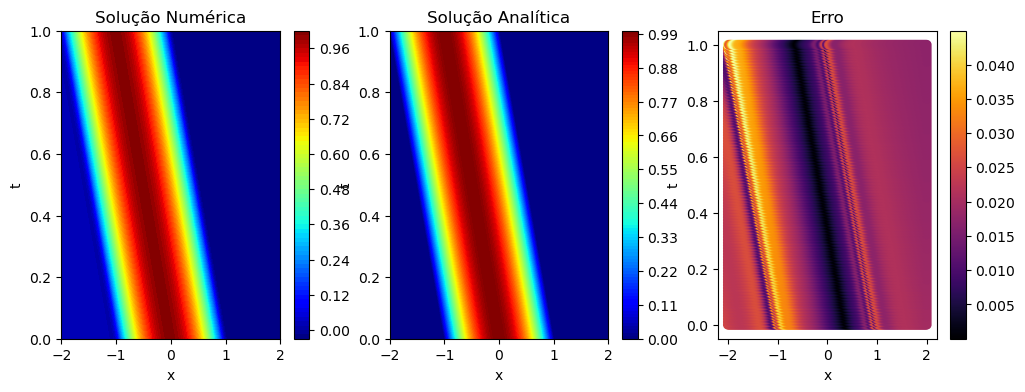

In [28]:
# Faz o gráfico da solução numérica
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.contourf(x_pred, t_pred, u_pred, 100, cmap='jet')
plt.colorbar()
plt.title('Solução Numérica')
plt.xlabel('x')
plt.ylabel('t')

# Faz o gráfico da solução analítica
plt.subplot(1, 3, 2)
plt.contourf(x_pred, t_pred, u_exact, 100, cmap='jet')
plt.colorbar()
plt.title('Solução Analítica')
plt.xlabel('x')
plt.ylabel('t')

# Faz o gráfico do erro absoluto
plt.subplot(1, 3, 3)
plt.scatter(x_pred, t_pred, c=abserror, cmap='inferno')
plt.colorbar()
plt.title('Erro')
plt.xlabel('x')
plt.ylabel('t')

plt.show()

Iteração 0, Perda: 0.16186511516571045
Iteração 10, Perda: 0.058388397097587585
Iteração 20, Perda: 0.011077298782765865
Iteração 30, Perda: 0.007224568165838718
Iteração 40, Perda: 0.005004429258406162
Iteração 50, Perda: 0.0041991425678133965
Iteração 60, Perda: 0.003072835737839341
Iteração 70, Perda: 0.0010233634384348989
Iteração 80, Perda: 0.000739299866836518
Iteração 90, Perda: 0.0007061393116600811
Iteração 100, Perda: 0.0006648835842497647
Iteração 110, Perda: 0.0006179028423503041
Iteração 120, Perda: 0.000603741966187954
Iteração 130, Perda: 0.000573206867557019
Iteração 140, Perda: 0.0004500849754549563
Iteração 150, Perda: 0.0003083609917666763
Iteração 160, Perda: 0.00025675370125100017
Iteração 170, Perda: 0.00022422413167078048
Iteração 180, Perda: 0.00020162062719464302
Iteração 190, Perda: 0.00018631003331393003
Iteração 200, Perda: 0.0001599542738404125
Iteração 210, Perda: 0.0001308115170104429
Iteração 220, Perda: 0.0001040331189869903
Iteração 230, Perda: 8.70504

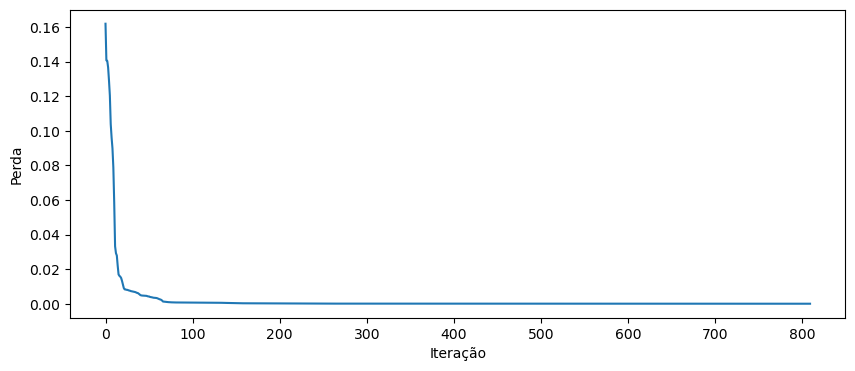

In [57]:
import numpy as np
import tensorflow as tf
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Definição dos limites
x_min, x_max = -2, 2
t_min, t_max = 0, 1

# Função de condição inicial
def initial_condition(x):
    return np.where(np.abs(x) <= 1, 1 - x**2, 0)

# Solução analítica (não utilizada na otimização, mas útil para validação)
def analytical_solution(t, x):
    return np.where(np.abs(x + t) <= 1, 1 - (x + t)**2, 0)

# Criação do modelo
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(2,)),  # entrada
        tf.keras.layers.Dense(80, activation='tanh'),
        tf.keras.layers.Dense(80, activation='tanh'),
        tf.keras.layers.Dense(80, activation='tanh'),
        tf.keras.layers.Dense(80, activation='tanh'),
        tf.keras.layers.Dense(1, activation=None)  # saída
    ])
    return model

# Função de perda para a EDP
def loss_function(model, x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        u = model(tf.concat([t, x], axis=1))
        u_t = tape.gradient(u, t)
        u_x = tape.gradient(u, x)
    residual = u_t - u_x
    return tf.reduce_mean(tf.square(residual))

# Função de perda total
def total_loss(model, x, t, x_ic, u_ic):
    loss_phys = loss_function(model, x, t)
    u_pred = model(tf.concat([tf.zeros_like(x_ic), x_ic], axis=1))
    loss_ic = tf.reduce_mean(tf.square(u_ic - u_pred))
    return loss_phys + loss_ic

# Funções para obter e definir os pesos
def get_weights(model):
    weights = model.trainable_variables
    weights = [w.numpy().flatten() for w in weights]
    weights = np.concatenate(weights)
    return weights

def set_weights(model, flat_weights):
    weights = model.trainable_variables
    shapes = [w.shape.as_list() for w in weights]
    sizes = [np.prod(shape) for shape in shapes]
    new_weights = []
    pos = 0
    for s, shape in zip(sizes, shapes):
        w_flat = flat_weights[pos:pos+s]
        w_new = w_flat.reshape(shape)
        new_weights.append(w_new)
        pos += s
    for i, w in enumerate(weights):
        w.assign(new_weights[i])

# Função a ser minimizada
def func_to_minimize(flat_weights):
    # Atualiza os pesos na rede neural
    set_weights(model, flat_weights)

    with tf.GradientTape() as tape:
        # Calcula a perda
        loss_value = total_loss(model, x_tf, t_tf, x_ic_tf, u_ic_tf)
    # Calcula os gradientes em relação aos pesos da rede neural
    gradients = tape.gradient(loss_value, model.trainable_variables)
    # Achata os gradientes em um vetor unidimensional
    grad_flat = []
    for grad in gradients:
        grad_flat.append(tf.reshape(grad, [-1]))
    grad_flat = tf.concat(grad_flat, axis=0)
    # Retorna a perda e o gradiente como arrays numpy
    return loss_value.numpy().astype(np.float64), grad_flat.numpy().astype(np.float64)

# Preparação dos dados de treinamento
x_train = (np.random.rand(100)*2*(x_max - x_min) + x_min).reshape(-1, 1)
t_train = (np.random.rand(100)*(t_max - t_min) + t_min).reshape(-1, 1)
x_train, t_train = np.meshgrid(x_train.flatten(), t_train.flatten())
x_train = x_train.flatten().reshape(-1, 1)
t_train = t_train.flatten().reshape(-1, 1)

x_ic = (np.random.rand(200)*(x_max - x_min) + x_min).reshape(-1, 1)
u_ic = initial_condition(x_ic)

# Convertendo para tensores do TensorFlow
x_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
t_tf = tf.convert_to_tensor(t_train, dtype=tf.float32)
x_ic_tf = tf.convert_to_tensor(x_ic, dtype=tf.float32)
u_ic_tf = tf.convert_to_tensor(u_ic, dtype=tf.float32)

# Criação do modelo
model = create_model()
initial_weights = get_weights(model)

# Classe para registrar o histórico de perdas
class LossHistory:
    def __init__(self):
        self.losses = []
        self.iter = 0

    def __call__(self, flat_weights):
        loss_value, _ = func_to_minimize(flat_weights)
        self.losses.append(loss_value)
        if self.iter % 10 == 0:
            print(f'Iteração {self.iter}, Perda: {loss_value}')
        self.iter +=1

loss_history = LossHistory()

# Execução da otimização L-BFGS-B
result = minimize(func_to_minimize, initial_weights, method='L-BFGS-B', jac=True,
                  callback=loss_history, options={'maxiter': 5000})

# Atualização dos pesos da rede neural com os pesos otimizados
set_weights(model, result.x)

# Plotar o histórico de perdas
plt.figure(figsize=(10,4))
plt.plot(loss_history.losses)
plt.xlabel('Iteração')
plt.ylabel('Perda')
plt.show()


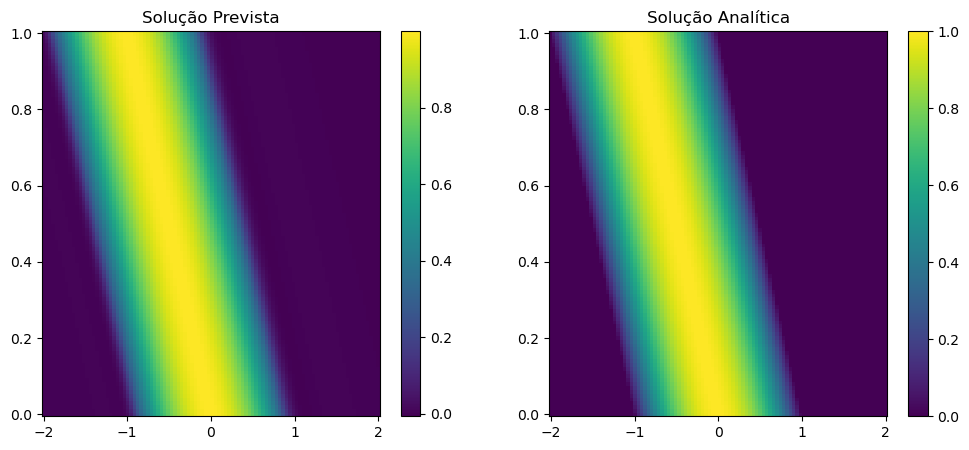

In [58]:
# Pontos para validação
x_val = np.linspace(x_min, x_max, 100)
t_val = np.linspace(t_min, t_max, 100)
x_val, t_val = np.meshgrid(x_val, t_val)
x_val_flat = x_val.flatten().reshape(-1,1)
t_val_flat = t_val.flatten().reshape(-1,1)

# Solução prevista pelo modelo
u_pred = model(tf.concat([t_val_flat, x_val_flat], axis=1))
u_pred = u_pred.numpy().reshape(x_val.shape)

# Solução analítica
u_exact = analytical_solution(t_val, x_val)

# Plotando as soluções
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.pcolor(x_val, t_val, u_pred, shading='auto')
plt.colorbar()
plt.title('Solução Prevista')

plt.subplot(1,2,2)
plt.pcolor(x_val, t_val, u_exact, shading='auto')
plt.colorbar()
plt.title('Solução Analítica')

plt.show()


In [77]:
# função para retornar o que o nosso modelo previu
def predict_solution(model, x, t):
    u_pred = model(tf.concat([t, x], axis=1))
    return u_pred.numpy().flatten()

# monta a grade para mostrar a solução
x_pred = np.linspace(x_min, x_max, 200)
t_pred = np.linspace(t_min, t_max, 200)
x_pred, t_pred = np.meshgrid(x_pred, t_pred)
x_pred_flat = x_pred.flatten().reshape(-1, 1)
t_pred_flat = t_pred.flatten().reshape(-1, 1)

# calcula a solução numérica
u_pred = predict_solution(model, x=tf.convert_to_tensor(x_pred_flat, dtype=tf.float32),
                          t=tf.convert_to_tensor(t_pred_flat, dtype=tf.float32))
u_pred = u_pred.reshape(x_pred.shape)

# calcula a solução analítica
u_exact = analytical_solution(t_pred, x_pred)

# calcula o erro relativo
error = np.linalg.norm(u_exact - u_pred) / np.linalg.norm(u_exact)
print(f'Erro Relativo: {error}')

# calcula o erro absoluto para fazer o gráfico
abserror = np.abs(u_exact - u_pred)

Erro Relativo: 0.010743259927432556


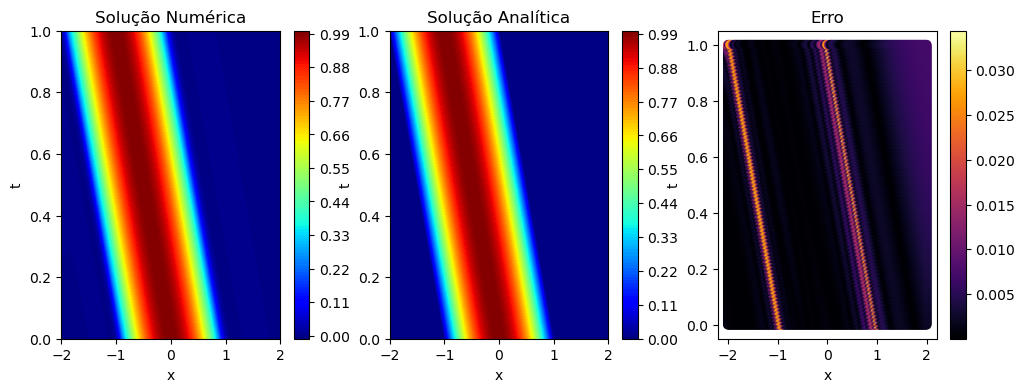

In [78]:
# Faz o gráfico da solução numérica
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.contourf(x_pred, t_pred, u_pred, 100, cmap='jet')
plt.colorbar()
plt.title('Solução Numérica')
plt.xlabel('x')
plt.ylabel('t')

# Faz o gráfico da solução analítica
plt.subplot(1, 3, 2)
plt.contourf(x_pred, t_pred, u_exact, 100, cmap='jet')
plt.colorbar()
plt.title('Solução Analítica')
plt.xlabel('x')
plt.ylabel('t')

# Faz o gráfico do erro absoluto
plt.subplot(1, 3, 3)
plt.scatter(x_pred, t_pred, c=abserror, cmap='inferno')
plt.colorbar()
plt.title('Erro')
plt.xlabel('x')
plt.ylabel('t')

plt.show()